# $P_{SW}$ Time Variability

Method for fitting: Lomb-Scargle Periodogram. See https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V for reference.

We are using the `LombScargle` function from the `astropy.timeseries` module

Lomb scargle designed to deal with gaps in the data.

In [1]:
#Importing libraries Numpy and Matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
import seaborn as sns

import datetime
from astropy.timeseries import LombScargle

# Some code to make the plots look nice!
sns.set_style('ticks')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette(palette = "colorblind")

import warnings
warnings.filterwarnings("ignore")

# 1. Masters data

In [2]:
# Masters data:
Year, Month, Day, Hour, Minute = np.loadtxt("Data masters et al.txt", usecols = (1,2,3,5,6), unpack = True, dtype='str', skiprows = 1)
X_Masters, Y_Masters, Z_Masters = np.loadtxt("Data masters et al.txt", usecols = (7,8,9), unpack = True, skiprows = 1)

In [3]:
#Computing the shock stand off position for masters data
r_Masters = np.sqrt(X_Masters**2+Y_Masters**2+Z_Masters**2)
costheta_Masters = X_Masters/r_Masters
L_Masters = r_Masters*(1+1.05*costheta_Masters)
R_Masters = L_Masters/2.05
P_Masters = (12.3 / R_Masters) ** 4.3

In [4]:
# Melchiors code for time formatting:

#Converting the the name of the month to a month number
Month_number = np.empty(0,dtype='str')
i = 0

while i < Month.size :
    m1 = datetime.datetime.strptime(Month[i], "%b").month          #Month name to Month number
    Month_number = np.append(Month_number,m1)                      #Creating a new array containing the month numbers
    i = i + 1
    
#The numpy datetime64 data type isn't able to identifies days/months with no 0 in fronts, 
#i.e we need to have 06 instead of 6 for the month of June for example

#Computing how many numbers there are in each data, i.e 6 returns 1 and 12 returns 2
length_checker = np.vectorize(len)
Month_number_length = length_checker(Month_number)     #For the Month
Day_number_length = length_checker(Day)                #For the Day

#Creating empty arrays for our new month/day arrays with zero in front when required
Month_number_with_zero = np.empty(0,dtype='str')
Day_number_with_zero = np.empty(0,dtype='str')

#Loop to add a zero in front of the number for the month 
i = 0
while i < Month_number.size : 
    if Month_number_length[i] == 1 :                                                #If just one number 
        m2 = np.char.add("0",Month_number[i])                                       #then add a zero in front
        Month_number_with_zero = np.append(Month_number_with_zero,m2)               #add the new number to the new array
        i = i + 1
    else :
        Month_number_with_zero = np.append(Month_number_with_zero,Month_number[i])  #otherwise do nothing
        i = i + 1

#Loop to add a zero in front of the number for the day 
i = 0
while i < Day.size : 
    if Day_number_length[i] == 1 :
        d1 = np.char.add("0",Day[i])
        Day_number_with_zero = np.append(Day_number_with_zero,d1)
        i = i + 1
    else :
        Day_number_with_zero = np.append(Day_number_with_zero,Day[i])
        i = i + 1
#Combining our separate time arrays (year,month,day,...) into a single one
time = np.char.add(Year,"-")
time = np.char.add(time, Month_number_with_zero)
time = np.char.add(time,"-")
time = np.char.add(time, Day_number_with_zero)
time = np.char.add(time,"T")
time = np.char.add(time, Hour)
time = np.char.add(time,":")
time = np.char.add(time, Minute)

#Creating a loop to make our two time arras in the same data type (datetime64)
time_Masters = np.empty(0,dtype='datetime64[m]')
i = 0

while i < time.size :
    time_Masters = np.append(time_Masters,np.datetime64(time[i]))
    i = i + 1


In [5]:
td = (time_Masters - time_Masters[0])/ np.timedelta64(1, 'D') # formatting time in units of days

frequency, power = LombScargle(td, P_Masters).autopower() # calculates periodogram
best_frequency = frequency[np.argmax(power)] # chooses highest freqency
best_period = 1 / best_frequency
print(best_period)
print("+- days")
loc = np.where(best_frequency == frequency)
sigma_frec = np.std(frequency[int(loc[0]-2):int(loc[0]+3)], ddof=1)
sigma_period = 1/(best_frequency ** 2) * sigma_frec
print(sigma_period)

9.116546563192903
+- days
0.0639225089460528


<IPython.core.display.Javascript object>


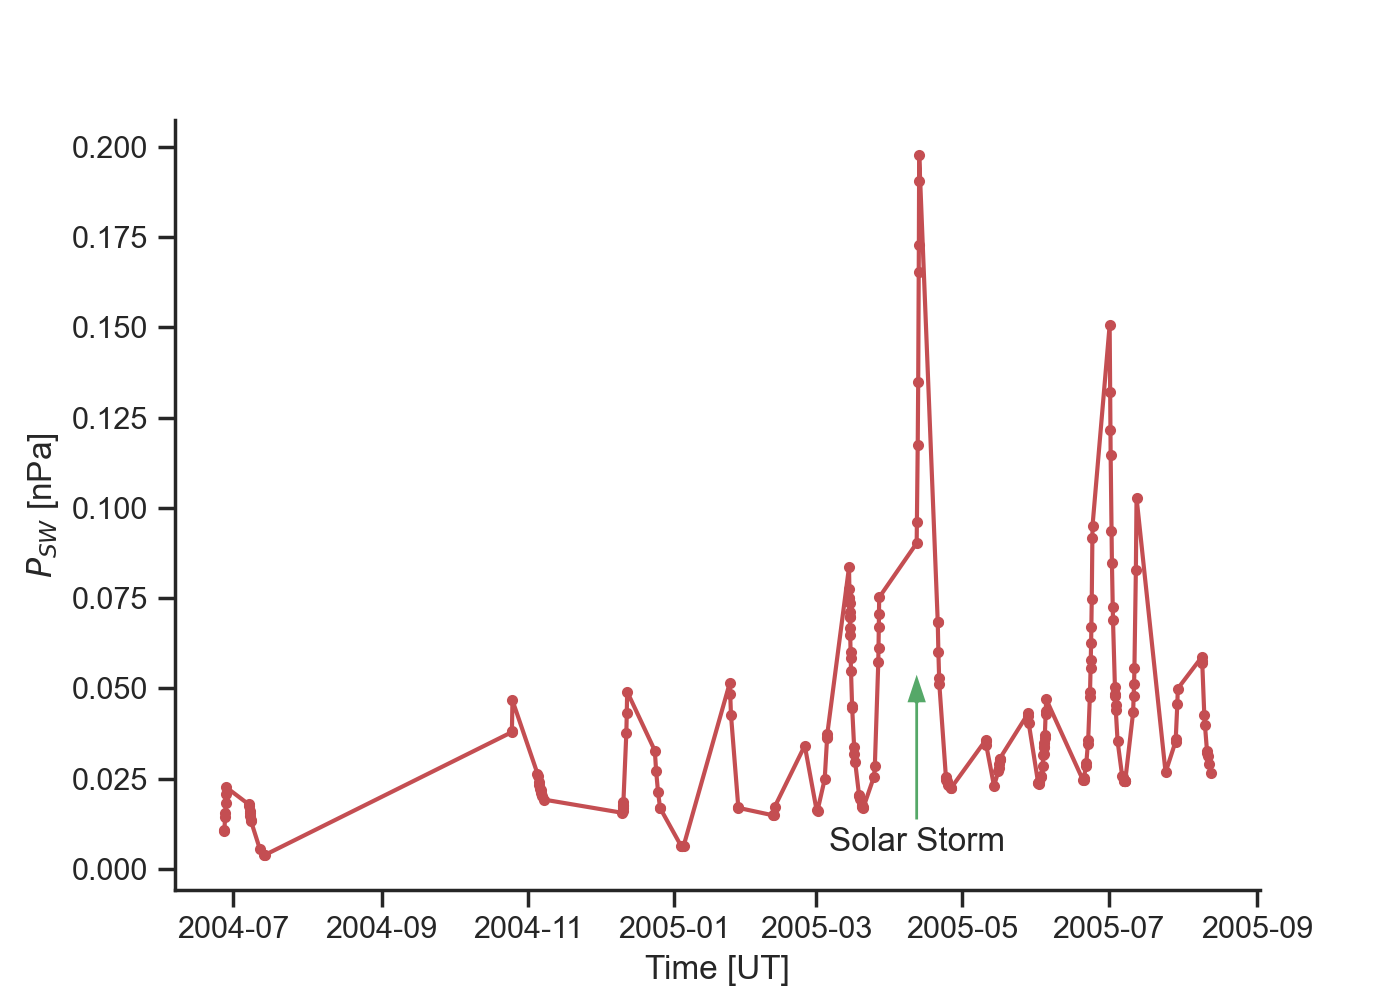

In [40]:
# Plot of p Wind through time
plt.figure(figsize = (7,5), dpi =100)
#plt.title("Psw through time")
plt.xlabel("Time [UT]")
plt.ylabel(r"$P_{SW}$ [nPa]")
plt.plot(time_Masters, P_Masters, "r.-")
plt.annotate('Solar Storm', xy = (time_Masters[95], 0.055),
             xytext = (time_Masters[95], 0.005),
             arrowprops = dict(facecolor = 'g', width = 2, headwidth = 8),
             horizontalalignment = 'center')
plt.savefig("PSW_time.pdf", dpi = 200)
plt.show()

<IPython.core.display.Javascript object>


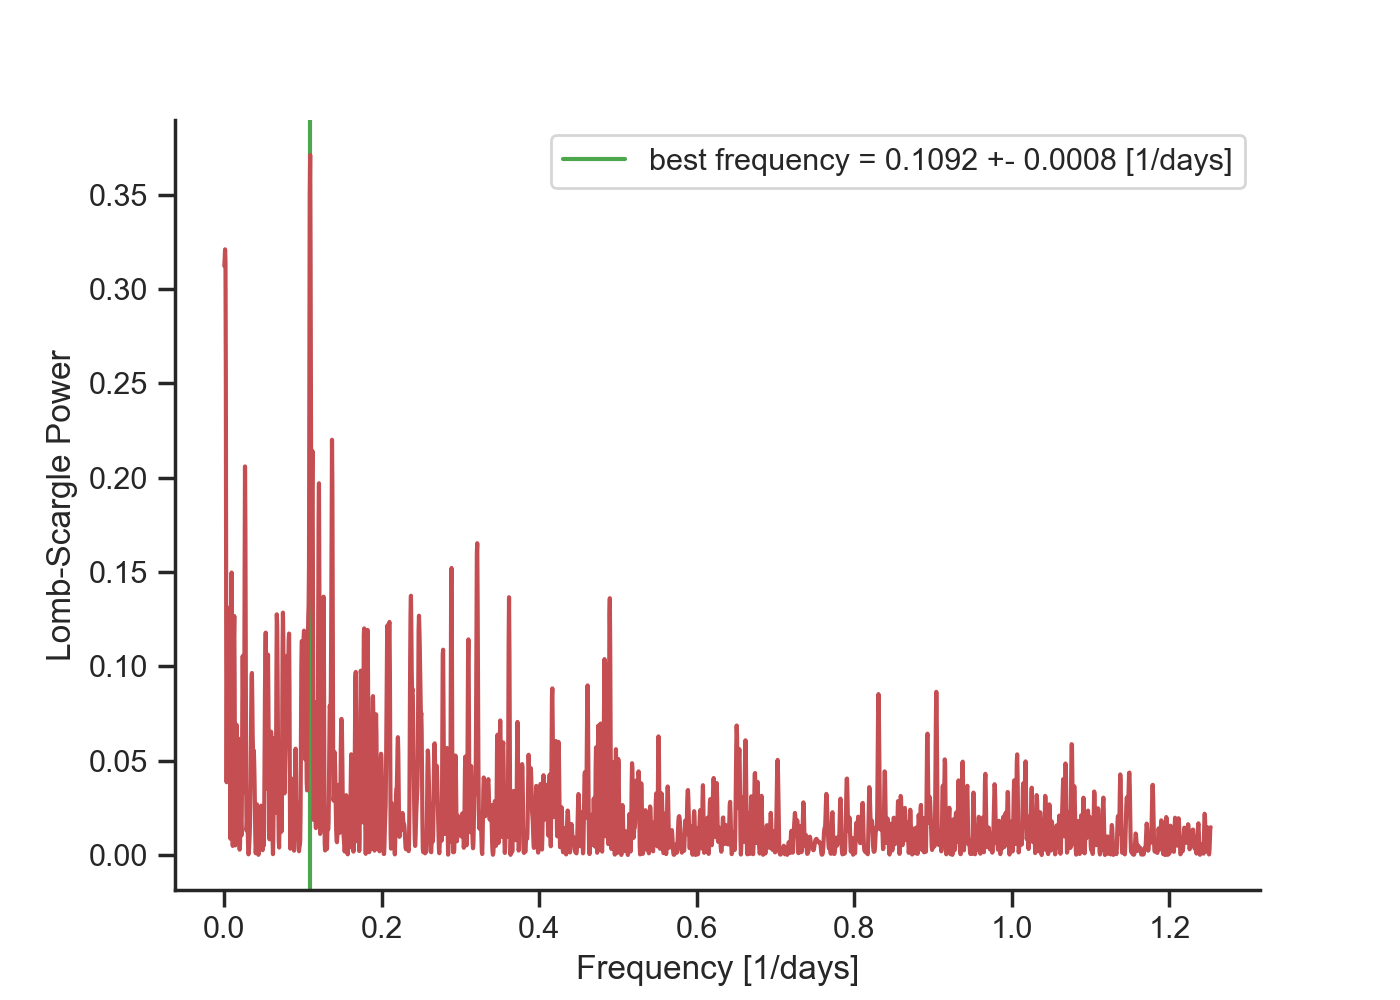

In [44]:
plt.figure(figsize = (7,5), dpi =100)
#plt.title(r"$P_{SW}$ Periodogram")
plt.axvline(best_frequency, color = "green", alpha = 0.7, \
            label= f"best frequency = {best_frequency:.4f} +- {sigma_frec:.4f} [1/days]")
plt.plot(frequency, power, "r-")
plt.xlabel("Frequency [1/days]")
plt.ylabel("Lomb-Scargle Power")
plt.legend(loc = "best")
plt.savefig("PSW_periodogram.pdf", dpi = 200)
plt.show()

# 2. Manual Data

In [8]:
# Our Data:
Cassini_time, X_SN,Y_SN,Z_SN, = np.loadtxt("2004_FGM_KSM_1M.TAB", usecols = (0,5,6,7), unpack = True, dtype='str')   
Year, Month, Day, Hour_Minute = np.loadtxt("Manual_BScrossings_records.txt", usecols = (2,3,4,5), unpack = True, dtype='str', skiprows = 1)

In [9]:
# Formatting
X_manual = []
Y_manual = []
Z_manual = []
time_manual = []
for i in range(len(Year)):
    dt_str = f'{Year[i]}-{Month[i]}-{Day[i]}T{Hour_Minute[i]}:30'
    time = np.datetime64(dt_str)
    time_manual.append(time)
    loc = np.where(Cassini_time == dt_str)
    loc = loc[0][0]
    Xi = float(X_SN[loc])
    Yi = float(Y_SN [loc])
    Zi = float(Z_SN [loc])
    X_manual.append(Xi)
    Y_manual.append(Yi)
    Z_manual.append(Zi)

    
X_manual = np.array(X_manual)
Y_manual = np.array(Y_manual)
Z_manual = np.array(Z_manual)
time_manual = np.array(time_manual)

In [10]:
#Computing the shock stand off position for masters data
r_manual = np.sqrt(X_manual**2+Y_manual**2+Z_manual**2)
costheta_manual = X_manual/r_manual
L_manual = r_manual*(1+1.05*costheta_manual)
R_manual = L_manual/2.05
P_manual = (12.3 / R_manual) ** 4.3

In [11]:
td = (time_manual - time_manual[0])/ np.timedelta64(1, 'D')

frequency, power = LombScargle(td, P_manual).autopower() # c
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency
uncertainty = best_period ** 2 / (td[len(td) - 1] - td[0])
print(best_period)
print("+-")
print(1/best_period) # approx 1 sigma for a gaussian

7.880372656607224
+-
0.12689755213055304


<IPython.core.display.Javascript object>


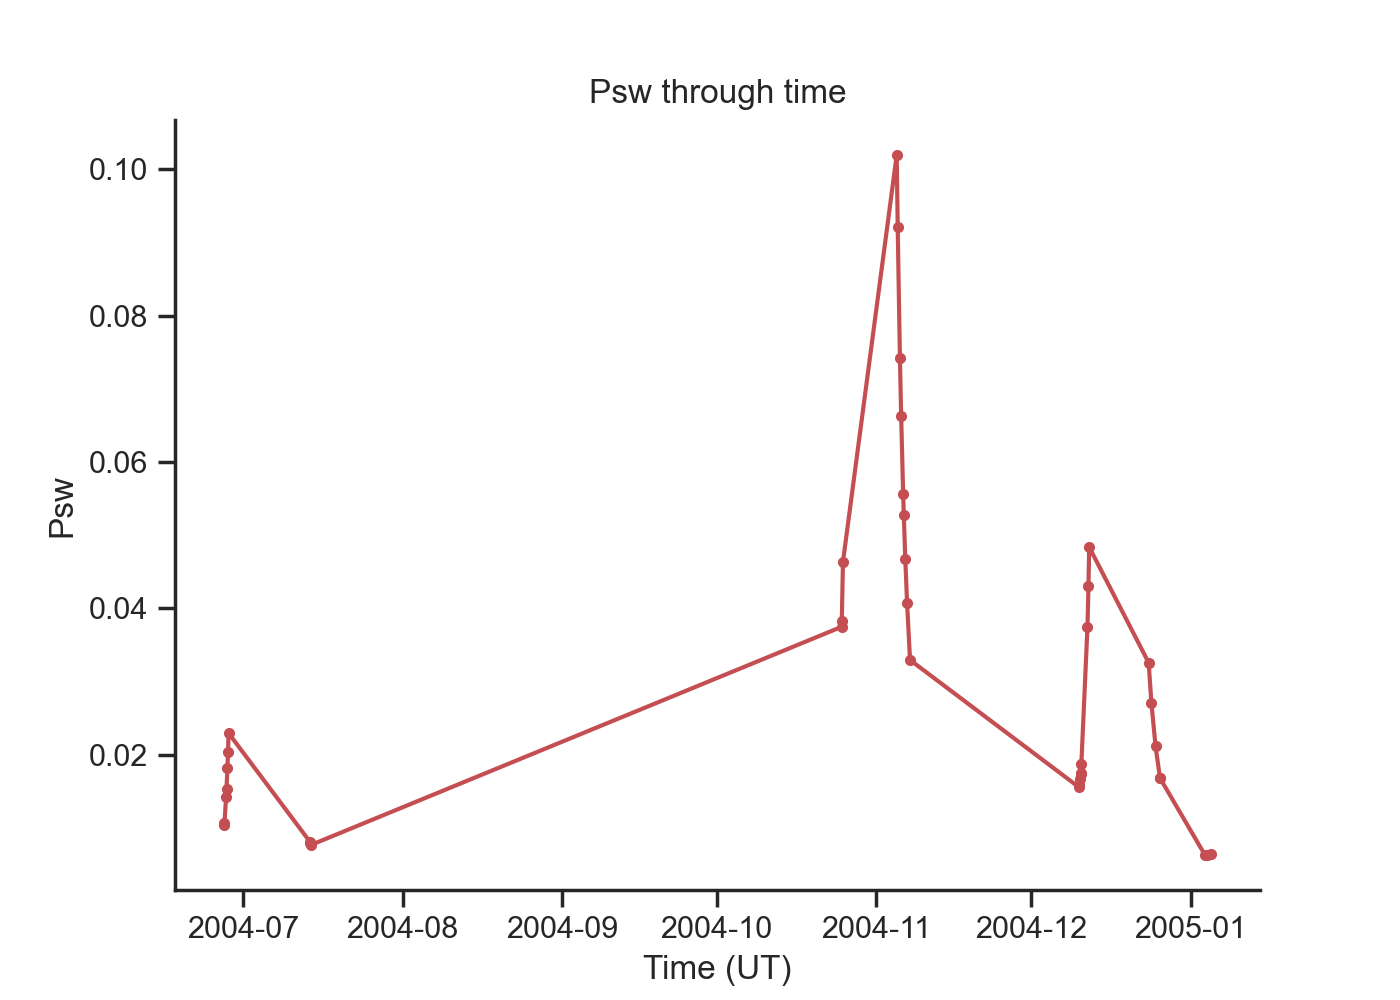

In [12]:
# Plot of p Wind through time
plt.figure(figsize = (7,5), dpi =100)
plt.title("Psw through time")
plt.xlabel("Time (UT)")
plt.ylabel("Psw")
plt.plot(time_manual, P_manual, "r.-")
plt.show()

<IPython.core.display.Javascript object>


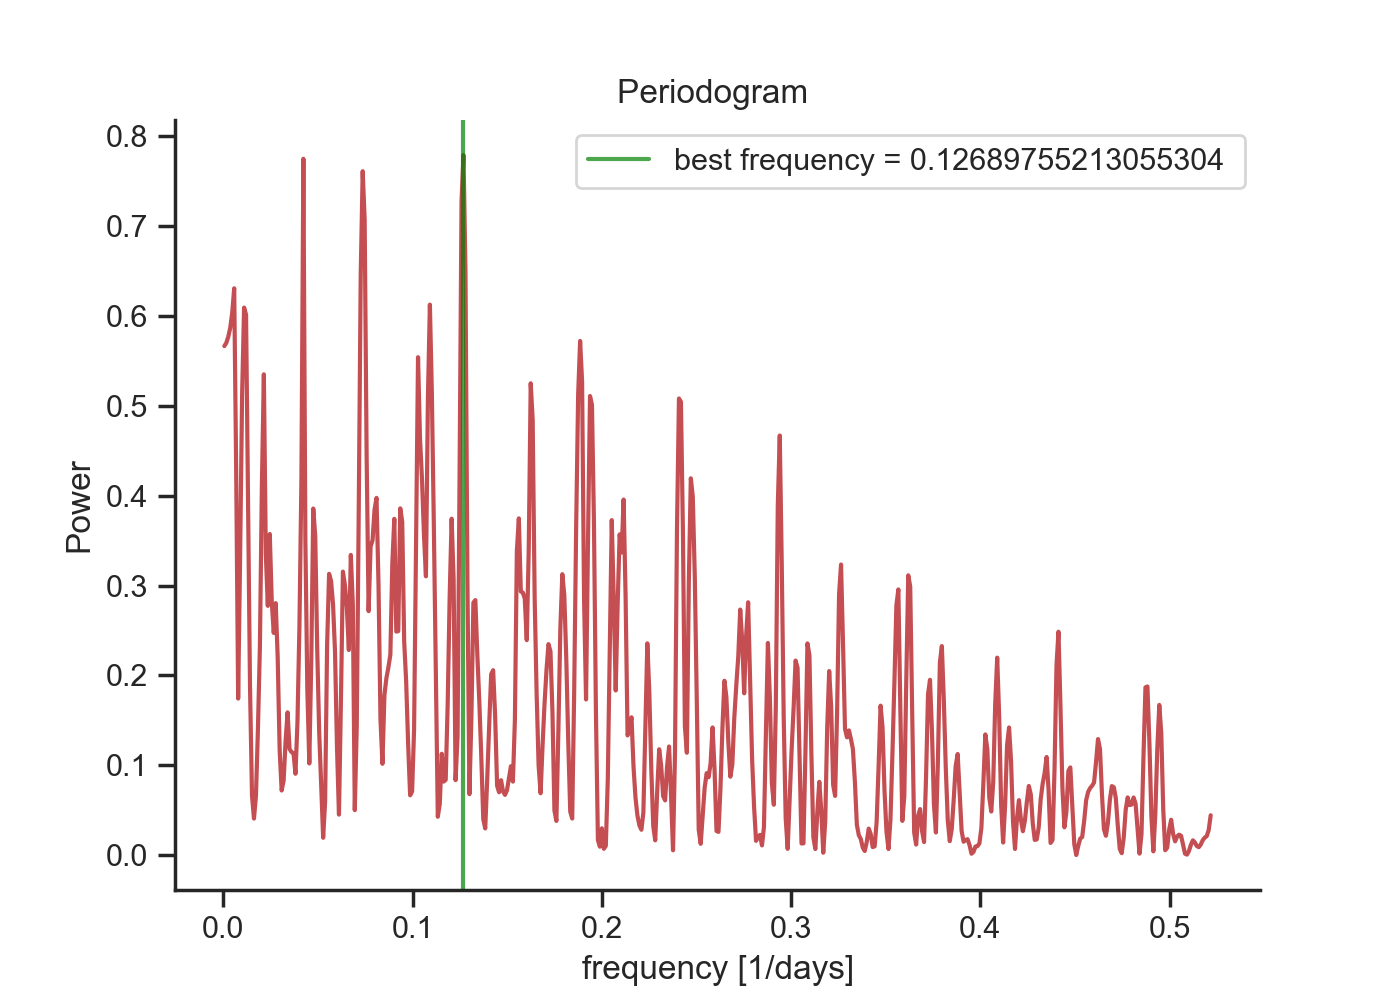

In [13]:
plt.figure(figsize = (7,5), dpi =100)
plt.title("Periodogram ")
plt.plot(frequency, power, "r-")
plt.xlabel("frequency [1/days]")
plt.ylabel("Power")
plt.axvline(best_frequency, color = "green", alpha = 0.7, label= f"best frequency = {best_frequency} ")
plt.legend(loc = "best")
plt.show()

# 3. R_SN Variability

In [14]:
td = (time_Masters - time_Masters[0])/ np.timedelta64(1, 'D') # formatting time in units of days

frequency, power = LombScargle(td, R_Masters).autopower() # calculates periodogram
best_frequency = frequency[np.argmax(power)] # chooses highest freqency
best_period = 1 / best_frequency
print(best_period)
print("+- days")
loc = np.where(best_frequency == frequency)
sigma_frec = np.std(frequency[int(loc[0]-2):int(loc[0]+3)], ddof=1)
sigma_period = 1/(best_frequency ** 2) * sigma_frec
print(sigma_period)

9.157154788418708
+- days
0.06449324280205003


<IPython.core.display.Javascript object>


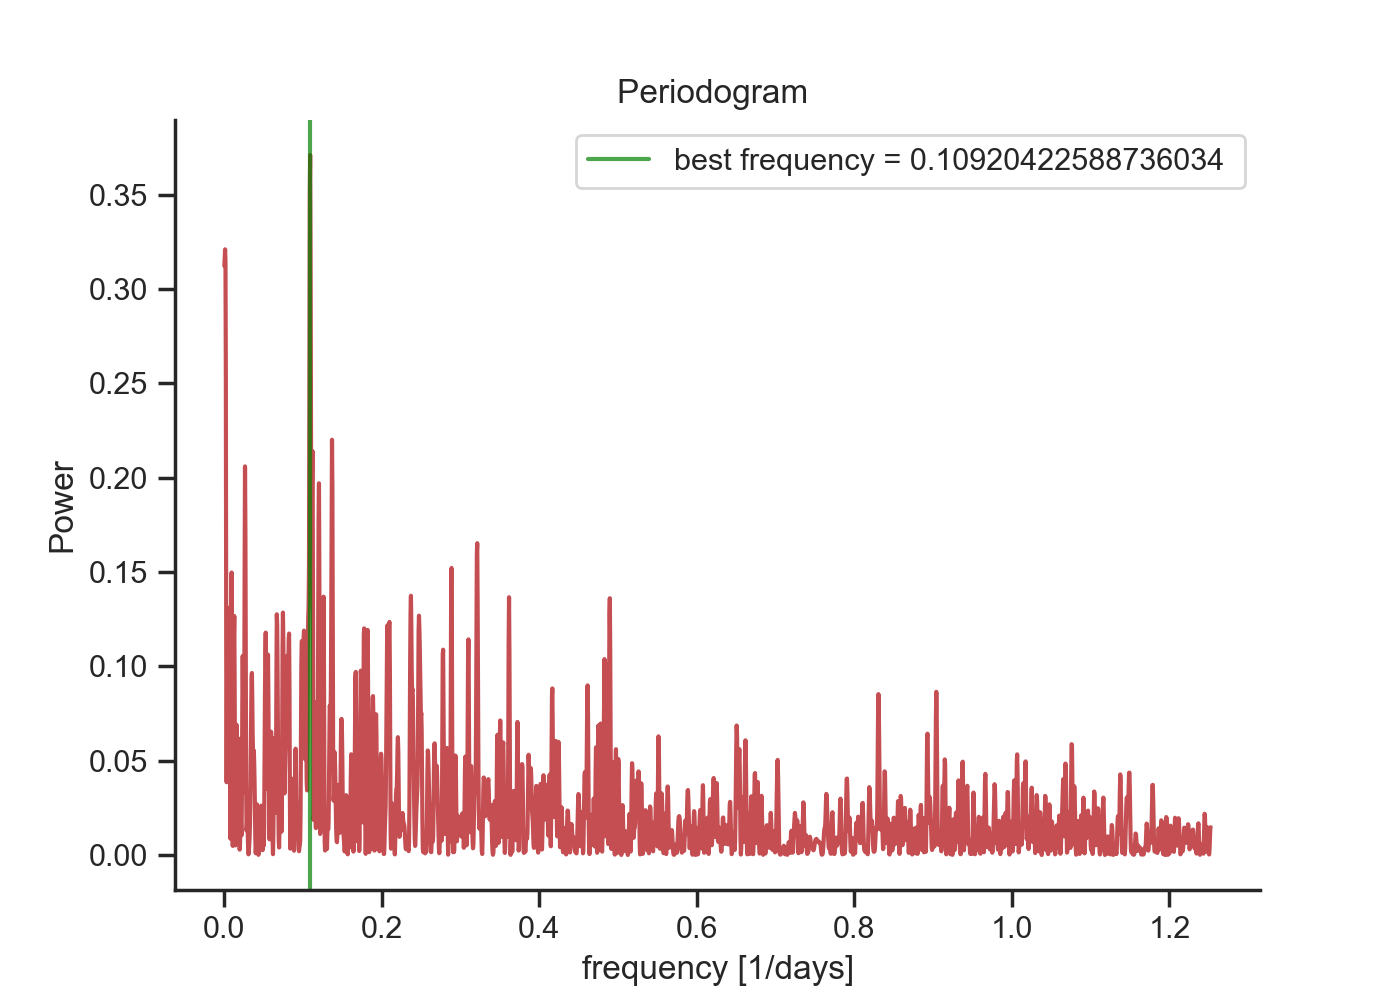

In [15]:
plt.figure(figsize = (7,5), dpi =100)
plt.title("Periodogram ")
plt.plot(frequency, power, "r-")
plt.xlabel("frequency [1/days]")
plt.ylabel("Power")
plt.axvline(best_frequency, color = "green", alpha = 0.7, label= f"best frequency = {best_frequency} ")
plt.legend(loc = "best")
plt.savefig("RSN_periodogram.png", dpi = 200)
plt.show()

<IPython.core.display.Javascript object>


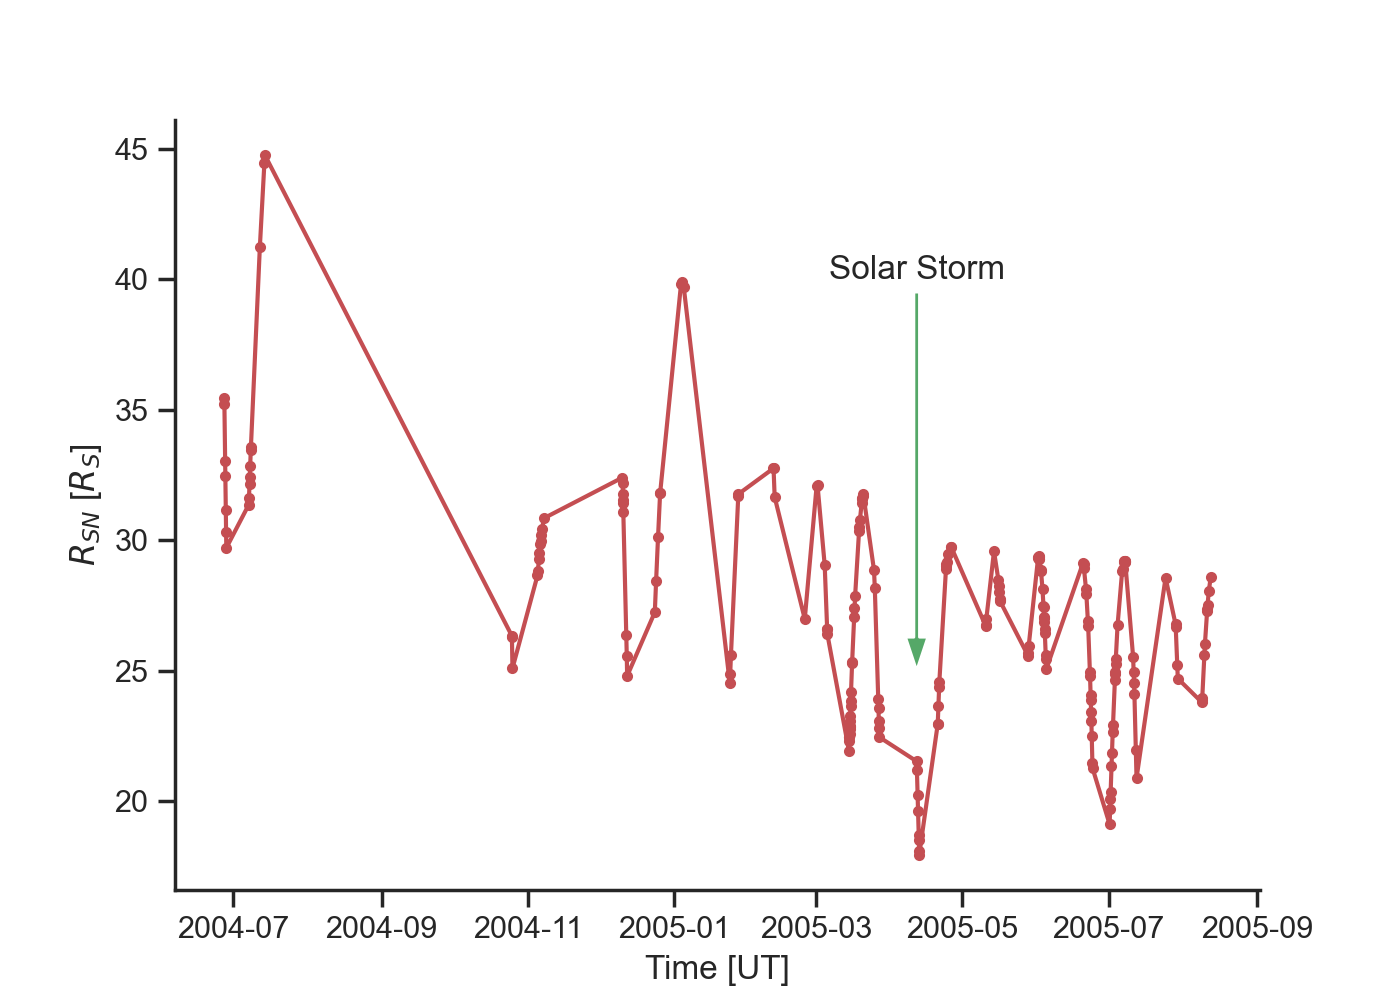

In [42]:
plt.figure(figsize = (7,5), dpi =100)
#plt.title("Psw through time")
plt.xlabel("Time [UT]")
plt.ylabel(r"$R_{SN}$ [$R_S$]")
plt.plot(time_Masters, R_Masters, "r.-")
plt.annotate('Solar Storm', xy = (time_Masters[95], 25),
             xytext = (time_Masters[95], 40),
             arrowprops = dict(facecolor = 'g', width = 2, headwidth = 8),
             horizontalalignment = 'center')
plt.savefig("RSN_time.pdf", dpi = 200)
plt.show()